# Lesson 3. Compare Lidar to Measured Tree Height

- Review how to summarize tabular data using pandas in Python.
- Create a scatter plot with a one to one line in Python using matplotlib.
- Merge two dataframes in Python.

In the previous lesson, you learned how to extract raster values from an area derived by creating a buffer region around each point in a shapefile. In this lesson, you will summarize the human made measurements and then compare them to lidar.

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import geopandas as gpd
import rasterstats as rs
from earthpy import spatial as es
import earthpy as et
import earthpy.plot as ep

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.axes_style("white")
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [3]:
sjer_lidar_chm_path = os.path.join("spatial-vector-lidar",
                                   "california",
                                   "neon-sjer-site",
                                   "2013",
                                   "lidar",
                                   "SJER_lidarCHM.tif")

# Load data
sjer_chm_data = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()

plot_buffer_path = os.path.join('spatial-vector-lidar',
                                'outputs',
                                'plot_buffer.shp')

# Extract zonal stats & create geodataframe
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data.values,
                                   affine=sjer_chm_data.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   nodata=0,
                                   stats="count mean max")

sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

## Is Lidar Derived Tree Height the Same As Human Measured Tree Height?
You have now done the following:

- You’ve opened and cleaned up some lidar canopy height model data
- You’ve extracted height values for the field plot locations where humans measured trees.
Next, you need to summarize the in situ collected tree height data, measured within circular plots across our study area. You will then compare the maximum measured tree height value to the maximum LiDAR derived height value for each circular plot.

For this lesson, you will use the a .csv (comma separate value) file, located in SJER/2013/insitu/veg_structure/D17_2013_SJER_vegStr.csv.

First determine the number many plots are in the tree height data. Note that the tree height data is stored in .csv format.

In [5]:
# Import & view insitu (field measured) data
path_insitu = os.path.join("spatial-vector-lidar",
                           "california",
                           "neon-sjer-site",
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")

sjer_insitu_all = pd.read_csv(path_insitu)

# View columns in data
sjer_insitu_all.columns

Index(['siteid', 'sitename', 'plotid', 'easting', 'northing', 'taxonid',
       'scientificname', 'indvidual_id', 'pointid', 'individualdistance',
       'individualazimuth', 'dbh', 'dbhheight', 'basalcanopydiam',
       'basalcanopydiam_90deg', 'maxcanopydiam', 'canopydiam_90deg',
       'stemheight', 'stemremarks', 'stemstatus', 'canopyform', 'livingcanopy',
       'inplotcanopy', 'materialsampleid', 'dbhqf', 'stemmapqf', 'plant_group',
       'common_name', 'aop_plot', 'unique_id'],
      dtype='object')

In [6]:
sjer_insitu = sjer_insitu_all[["siteid",
                               "sitename",
                               "plotid",
                               "stemheight",
                               "scientificname"]]

sjer_insitu.head()

,siteid,sitename,plotid,stemheight,scientificname
0,SJER,San Joaquin,SJER128,18.2,Pinus sabiniana
1,SJER,San Joaquin,SJER2796,3.3,Arctostaphylos viscida
2,SJER,San Joaquin,SJER272,1.7,Arctostaphylos viscida
3,SJER,San Joaquin,SJER112,2.1,Arctostaphylos viscida
4,SJER,San Joaquin,SJER272,3.0,Arctostaphylos viscida


## Summarize Tree Height Data Using Pandas
You want to calculate a summary value of max tree height (the tallest tree measured) in each plot. You have a unique id for each plot - plotid that can be used to group the data. The tree height values themselves are located in the stemheight column.

You can calculate this by using the .groupy() method in pandas.

The steps are

- .groupby() - group the data by the plotid column - your unique identifier for each plot.
- **.agg()** - provide the summary statistics that you want to return for each plot. in this case max and mean.
- below ['stemheight]` is the name of the column that you want to summarize.

#### SJER_insitu.groupby('plotid').agg(['mean', 'min', 'max'])['stemheight']

In [7]:
insitu_stem_ht = sjer_insitu.groupby('plotid').agg(
    ['mean', 'max'])['stemheight']

insitu_stem_ht.head()

,mean,max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [9]:
# Rename each column - appending “insitu”
insitu_stem_ht.rename(columns={"mean": "insitu_mean",
                               "max": "insitu_max"},
                      inplace=True)  # Modify the dataframe columns

insitu_stem_ht.head()

,insitu_mean,insitu_max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [10]:
# Reset the index (plotid)
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

,plotid,insitu_mean,insitu_max
0,SJER1068,3.866667,19.3
1,SJER112,8.221429,23.9
2,SJER116,8.218750,16.0
3,SJER117,6.512500,11.0
4,SJER120,7.600000,8.8


## Merge InSitu Data With Spatial Dataframe
Once you have our summarized insitu data, you can merge it into the centroids data frame. Merge requires two data.frames and the names of the columns containing the unique ID that we will merge the data on. In this case, you will merge the data on the plot_id column. Notice that it’s spelled slightly differently in both data.frames so we’ll need to tell Python what it’s called in each dataframe.

Note that if you want to merge two GeoDataFrames together, you cannot use the standard Pandas merge function. This will turn the GeoDataFrame into a regular DataFrame. Instead, you need to use the merge method of a GeoDataFrame object, like so:

In [16]:
# Rename columns so that we know which columns represent lidar values
sjer_lidar_height_df = sjer_lidar_height_df.rename(
    columns={'max': 'lidar_max',
             'mean': 'lidar_mean',
             'min': 'lidar_min'})

# Join lidar and human measured tree height data
sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                                               left_on='Plot_ID',
                                               right_on='plotid') # right in situ
sjer_final_height.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,count,plotid,insitu_mean,insitu_max
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348,161,SJER1068,3.866667,19.3
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,443,SJER112,8.221429,23.9
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,643,SJER116,8.218750,16.0
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347,245,SJER117,6.512500,11.0
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176,17,SJER120,7.600000,8.8


## Column Names Matter
Take note that while you you don’t have to rename the columns as you did above in order to successfully computer your final merged dataframe, it helps if you do because

- Now anyone looking at your data knows what each column represents.
- If you export the data to a text file, your columns are named expressively
- If you return to this analysis in 6 months, you will still be able to quickly understand what data are in each column if they are well named!

##  Plot Data (CHM vs Measured)
You’ve now merged the two dataframes together. Your are ready to create your first scatterplot of the data. You can use the pandas .plot() to create a scatterplot (or you can use matplotlib directly). The example below uses pandas plotting.



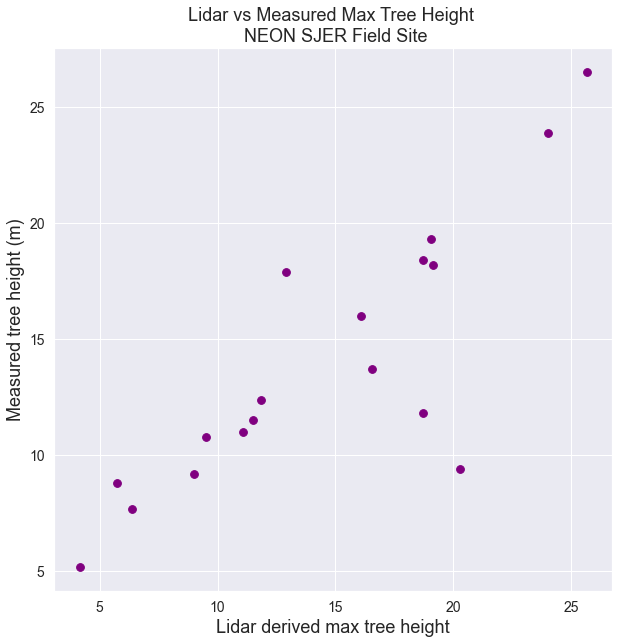

In [15]:
# Convert to a dataframe so you can use standard pandas plotting
sjer_final_height_df = pd.DataFrame(sjer_final_height)

fig, ax = plt.subplots(figsize=(10, 10))

sjer_final_height_df.plot('lidar_max',
                          'insitu_max',
                          kind='scatter',
                          fontsize=14, s=60,
                          color="purple",
                          ax=ax)

ax.set(xlabel="Lidar derived max tree height",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Max Tree Height \n NEON SJER Field Site")

plt.show()

Next, let’s fix the plot adding a 1:1 line and making the x and y axis the same .



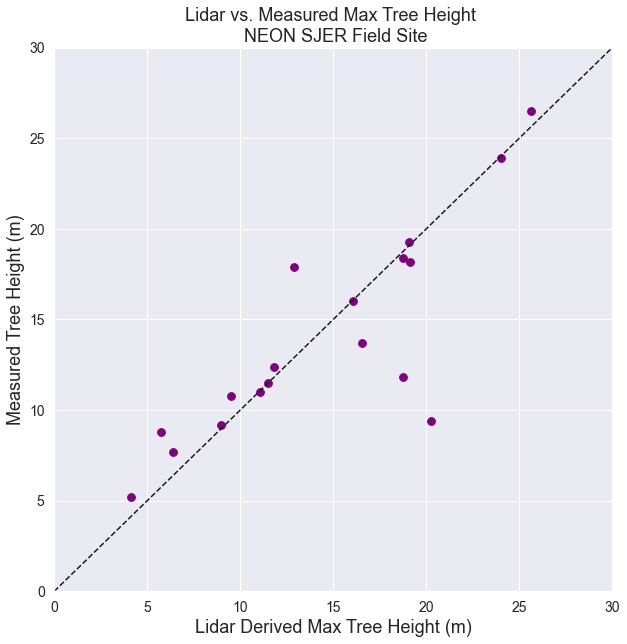

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

sjer_final_height_df.plot('lidar_max',
                          'insitu_max',
                          kind='scatter',
                          fontsize=14,
                          color="purple",
                          s=60, ax=ax)

ax.set(xlabel="Lidar Derived Max Tree Height (m)",
       ylabel="Measured Tree Height (m)",
       title="Lidar vs. Measured Max Tree Height \n NEON SJER Field Site")

# Add 1:1 line
ax.plot((0, 1), (0, 1),
        transform=ax.transAxes, ls='--', c='k')

# Adjust x and y axis limits
ax.set(xlim=[0, 30], ylim=[0, 30])
plt.show()

In [19]:
# Export the final data frame as a csv file
outpath = os.path.join("spatial-vector-lidar",
                       "outputs",
                       "sjer-lidar-insitu-merge.csv")

sjer_final_height_df.to_csv(outpath)

## Create Map of Plot Locations Sized by Tree Height
Finally, you may want to create a map where points are sized according to tree height. To do that you

- Create or use a point geometry for each site location. In the case below we are using the data.frame that had the buffered points, and updating the geometry so that it is a point rather than the buffered polygon geometry.
- Then you set the point markersize using an attribute in your geodataframe. In the example below you use insitu_maxht

In [20]:
# Convert the geometry column to contain points
sjer_final_height['geometry'] = sjer_final_height.centroid
sjer_final_height.head()

sjer_final_height['insitu_max']

0     19.3
1     23.9
2     16.0
3     11.0
4      8.8
5     18.2
6     13.7
7     12.4
8      9.4
9     17.9
10     9.2
11    11.8
12    11.5
13    10.8
14     5.2
15    26.5
16    18.4
17     7.7
Name: insitu_max, dtype: float64

Plot the points by tree height.

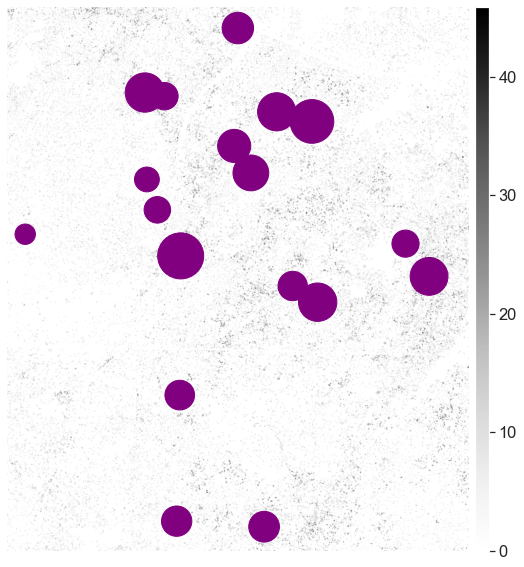

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ep.plot_bands(sjer_chm_data,
              cmap='Greys',
              extent=plotting_extent(sjer_chm_data,
                                     sjer_chm_data.rio.transform()),
              ax=ax,
              scale=False)

# Plot centroids of each geometry as points so that you can control their size
sjer_final_height.centroid.plot(ax=ax,
                                marker='o',
                                markersize=sjer_final_height['insitu_max'] * 80,
                                c='purple')
ax.set_axis_off()
plt.show()

## Optional - Create Difference Bar Plot: Lidar vs Measured
The last comparison that you may wish to explore is the plot by plot difference between lidar and measured tree height data. This is often helpful when you are trying to troubleshoot outlier values in your data. For instance you may notice that a few plots have very large differences between lidar and measured tree height.

You may decide to either:

- Visit the sites if you are close to the field site or
- Explore imagery for the sites to see if you can figure out a good reason for why the results may be so different.


Below you do the following

- You first subtract field measured tree height from lidar estimates
- Then you create a barplot of that value

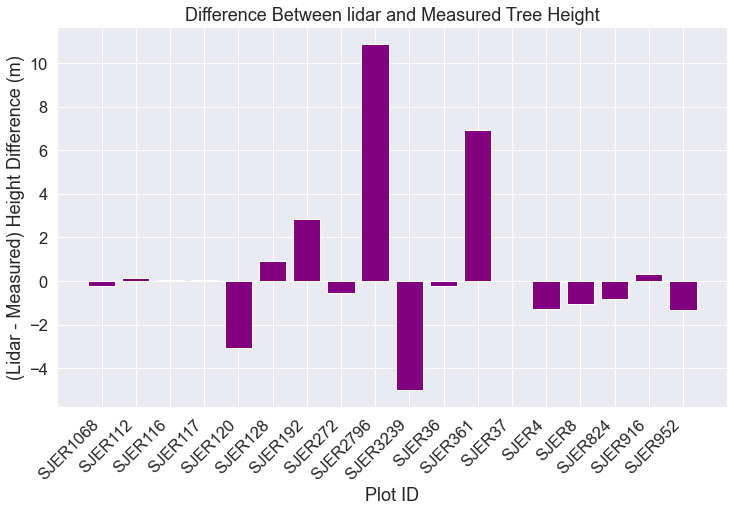

In [22]:
# Calculate difference
sjer_final_height["lidar_measured"] = sjer_final_height["lidar_max"] - \
    sjer_final_height["insitu_max"]

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(sjer_final_height['plotid'],
       sjer_final_height['lidar_measured'],
       color="purple")

ax.set(xlabel='Plot ID', ylabel='(Lidar - Measured) Height Difference (m)',
       title='Difference Between lidar and Measured Tree Height')

plt.setp(ax.get_xticklabels(),
         rotation=45, horizontalalignment='right')
plt.show()